In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [89]:
df = pd.read_csv("m_sand_concrete_dataset.csv")
df

,Cement,M_sand,Fly_ash,W_B_ratio,Water_reducer,Gravel,Compressive_strength,CPC
0,404.791210,716.707805,25.596509,0.319968,3.913121,1278.338629,228.661746,162.619943
1,337.775688,638.563169,93.604357,0.478330,3.975574,1231.632520,193.437545,154.611738
2,421.719584,548.381534,16.460782,0.343852,4.730135,1209.436235,205.165174,148.979534
3,389.473606,650.313433,4.491062,0.547399,1.266917,1251.394066,189.348505,160.160457
4,268.835470,545.693631,43.509706,0.393100,2.950379,1012.045390,154.693854,132.971430
...,...,...,...,...,...,...,...,...
81,331.277372,742.475442,24.783956,0.580782,4.007409,1252.597963,208.001125,157.217033
82,412.804077,595.141668,23.666236,0.341222,1.192764,1016.670375,201.796756,139.879017
83,283.394584,785.869819,74.601428,0.587664,4.247044,1084.183431,191.573191,148.668242
84,254.542415,587.275351,81.656876,0.540265,0.286160,1100.239012,165.576196,130.780271


In [90]:
df = df.copy()
iso = IsolationForest(contamination=0.1, random_state=42)
X_features = df.drop(columns=["Compressive_strength", "CPC"])
outlier_pred = iso.fit_predict(X_features)

df_clean = df[outlier_pred == 1].reset_index(drop=True)
print("Shape original:", df.shape)
print("Shape after remove outlier:", df_clean.shape)

Shape original: (86, 8)
Shape after remove outlier: (77, 8)


In [91]:
features_names = df_clean.iloc[:, :6].columns
target_names = df_clean.iloc[:, 6:].columns

X = df_clean.iloc[:, :6].values   # feature
y = df_clean.iloc[:, 6:].values   # label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [92]:
def plot_shap_multioutput(model, X, features_names, target_names,
                          model_name="Model",
                          max_display=10, nsample=50, random_state=42):
    
    if X.shape[0] > nsample:
        X_background = shap.sample(X, nsample, random_state=random_state)
    else:
        X_background = X

    n_targets = len(model.estimators_)
    fig, axes = plt.subplots(1, n_targets, figsize=(10*n_targets, 6))

    if n_targets == 1:
        axes = [axes]

    for i, (est, ax) in enumerate(zip(model.estimators_, axes)):
        target_name = target_names[i] if i < len(target_names) else f"Target {i+1}"

        if "xgb" in str(type(est)).lower():
            explainer = shap.TreeExplainer(est)
            shap_values = explainer.shap_values(X)
        else:
            explainer = shap.KernelExplainer(est.predict, X_background)
            shap_values = explainer.shap_values(X[:nsample])

        mean_shap = np.abs(shap_values).mean(axis=0)
        feature_importance = dict(zip(features_names, mean_shap))
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:max_display]

        features = [f[0] for f in sorted_features]
        importances = [f[1] for f in sorted_features]

        bars = ax.barh(features, importances, color="steelblue")
        ax.invert_yaxis()
        ax.set_title(f"{model_name} - {target_name}\nFeature Importance (mean |SHAP|)")
        ax.set_xlabel("mean(|SHAP value|)")

        for bar, val in zip(bars, importances):
            ax.text(val, bar.get_y() + bar.get_height()/2,
                    f"{val:.3f}", va='center', ha='left', fontsize=9)

    plt.tight_layout()
    plt.show()

In [93]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_multioutput_model(model, X_train, y_train, X_test, y_test, model_name):
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Target 1: CS
    r2_cs_train  = r2_score(y_train[:, 0], y_pred_train[:, 0])
    rmse_cs_train = np.sqrt(mean_squared_error(y_train[:, 0], y_pred_train[:, 0]))
    r2_cs_test  = r2_score(y_test[:, 0], y_pred_test[:, 0])
    rmse_cs_test = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_test[:, 0]))

    # Target 2: CPC
    r2_cpc_train  = r2_score(y_train[:, 1], y_pred_train[:, 1])
    rmse_cpc_train = np.sqrt(mean_squared_error(y_train[:, 1], y_pred_train[:, 1]))
    r2_cpc_test  = r2_score(y_test[:, 1], y_pred_test[:, 1])
    rmse_cpc_test = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_test[:, 1]))

    result = {
        ("CS", "R2_Train"): r2_cs_train,
        ("CS", "RMSE_Train"): rmse_cs_train,
        ("CS", "R2_Test"): r2_cs_test,
        ("CS", "RMSE_Test"): rmse_cs_test,
        ("CPC", "R2_Train"): r2_cpc_train,
        ("CPC", "RMSE_Train"): rmse_cpc_train,
        ("CPC", "R2_Test"): r2_cpc_test,
        ("CPC", "RMSE_Test"): rmse_cpc_test,
    }

    return pd.Series(result, name=model_name)

In [94]:
import pickle
import shap
with open("best_xgb_model.pkl", "rb") as f:
    xgb = pickle.load(f)
with open("best_SVR_model.pkl", "rb") as f:
    svr = pickle.load(f)
with open("best_GPR_model.pkl", "rb") as f:
    gpr = pickle.load(f)

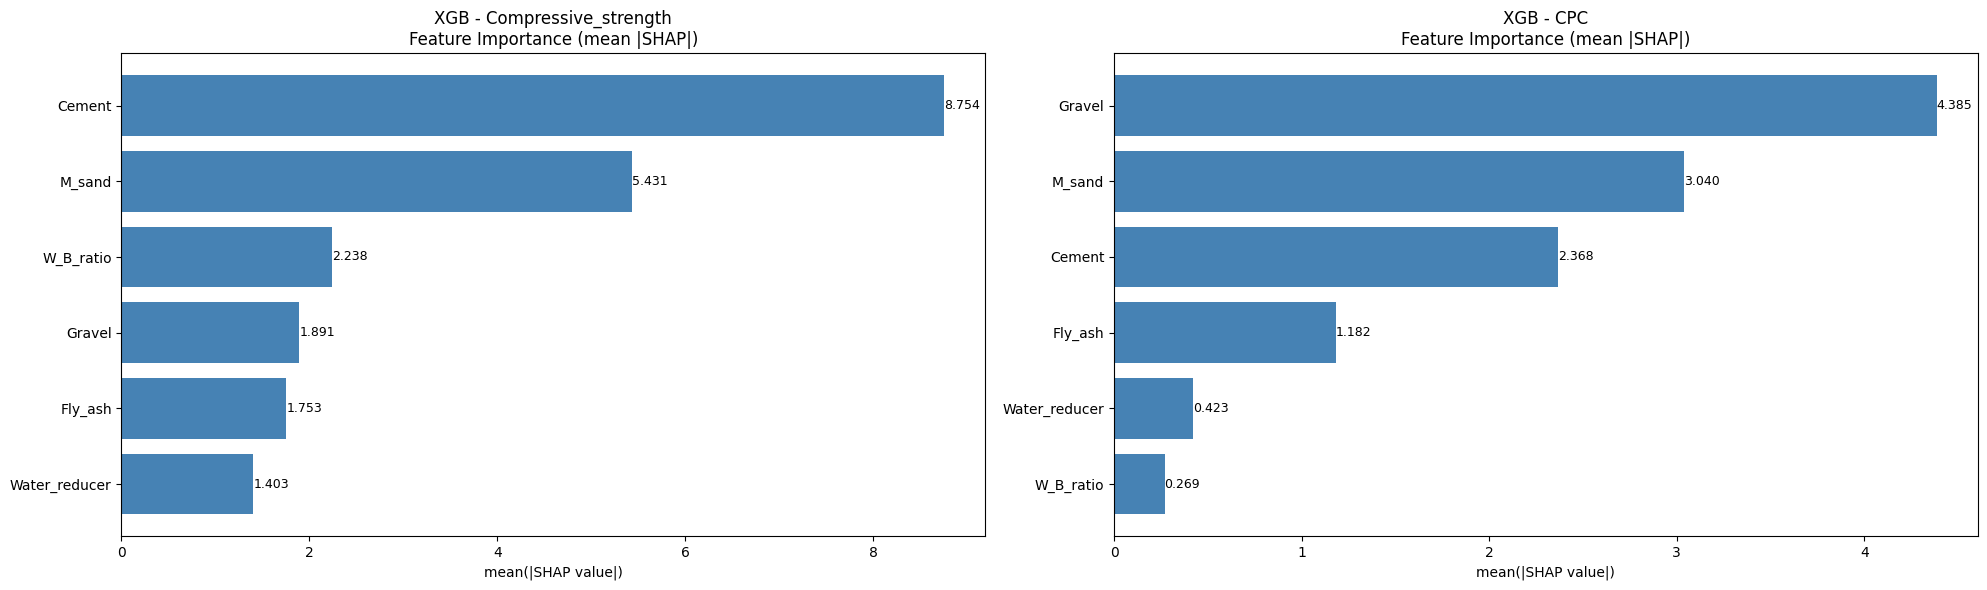

In [95]:
plot_shap_multioutput(xgb, X_train, features_names, target_names, model_name="XGB")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 88.79it/s]


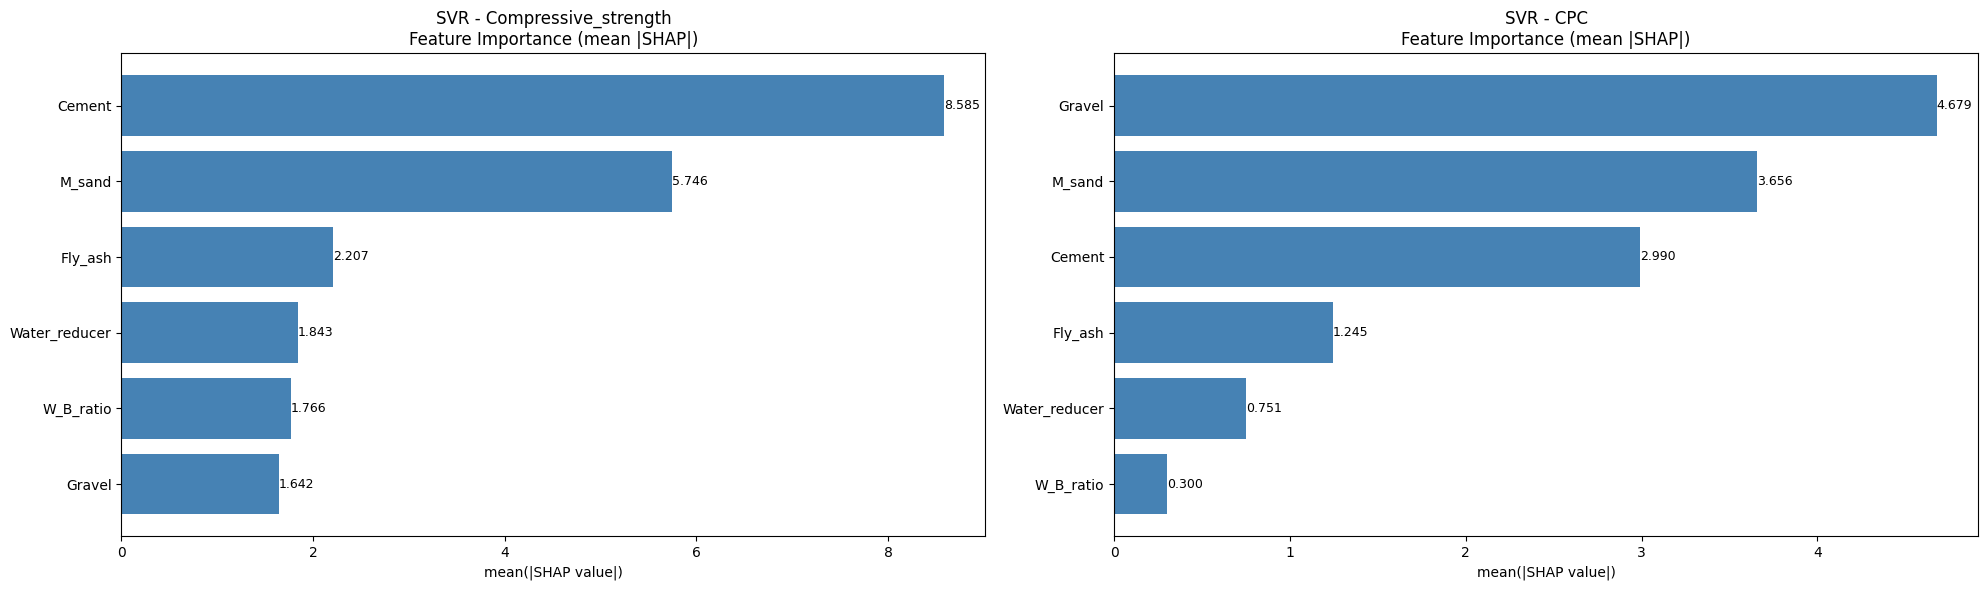

In [96]:
plot_shap_multioutput(svr, X_train, features_names, target_names, model_name="SVR")

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.22it/s]


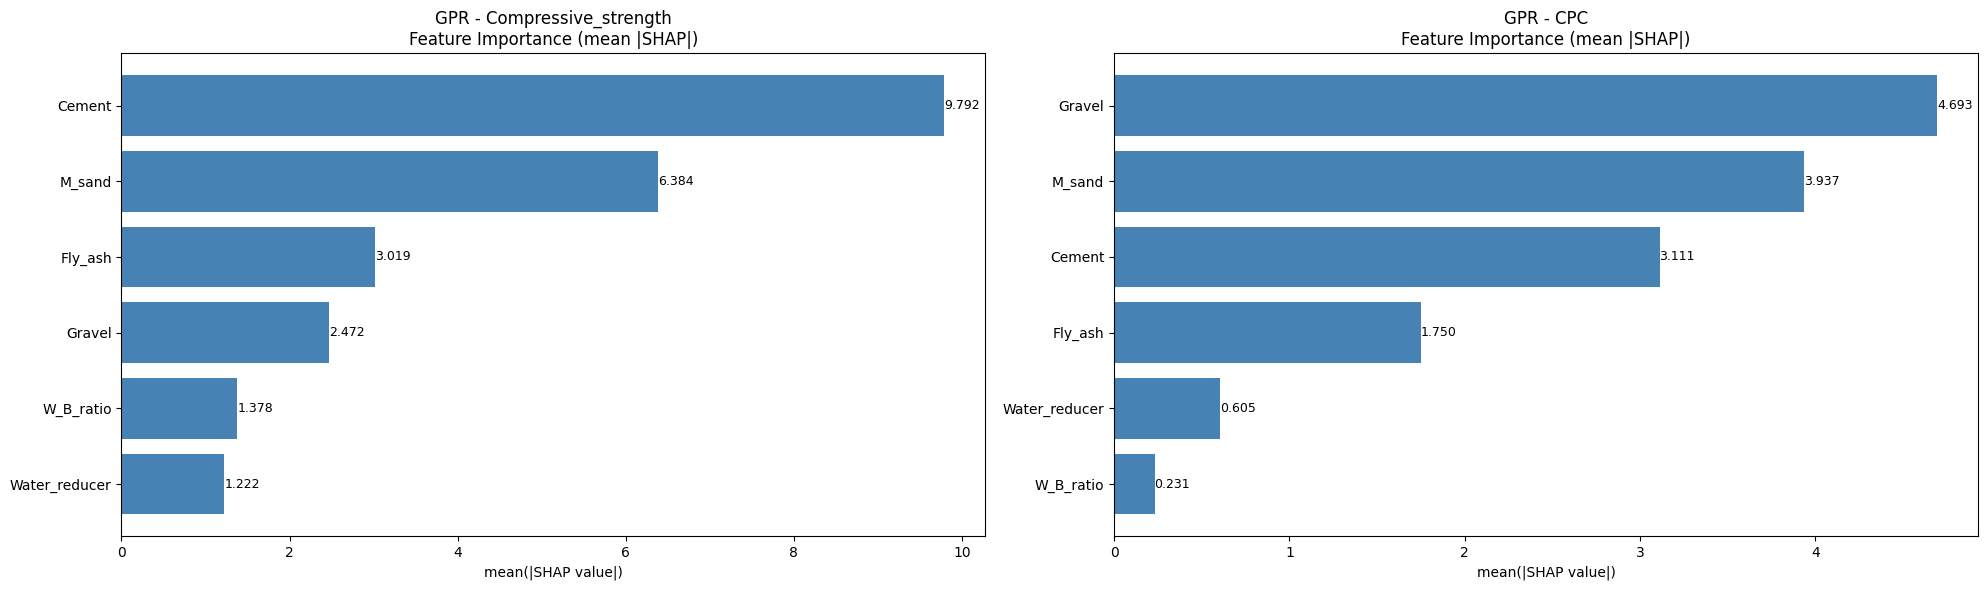

In [97]:
plot_shap_multioutput(gpr, X_train, features_names, target_names, model_name="GPR")

In [98]:
df_results = pd.DataFrame([
    evaluate_multioutput_model(xgb, X_train, y_train, X_test, y_test, "XGB"),
    evaluate_multioutput_model(svr, X_train, y_train, X_test, y_test, "SVR"),
    evaluate_multioutput_model(gpr, X_train, y_train, X_test, y_test, "GPR"),
])

df_results.columns = pd.MultiIndex.from_tuples(df_results.columns)
df_results

CS                                      CPC                       \
     R2_Train RMSE_Train   R2_Test RMSE_Test  R2_Train RMSE_Train   R2_Test   
XGB  0.984937   1.873079  0.878474  7.720016  0.959625   1.689161  0.865421   
SVR  0.884521   5.186297  0.910887  6.610827  0.895116   2.722497  0.868118   
GPR  0.902099   4.775285  0.930983  5.817829  0.893708   2.740702  0.844695   

               
    RMSE_Test  
XGB  3.193794  
SVR  3.161626  
GPR  3.430914